In [1]:
import tensorflow as tf
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/Model_13_04_2022'
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DRll01","Mll01","DEtall_SS","DPhill_SS","jet_pseudoscore_DL1r0","jet_pseudoscore_DL1r1","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
samples, feature_names, class_names, class_no = load_input_file('data/sstt_multiclass_background_final.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DRll01
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  DPhill_SS
Ignoring feature:  jet_pseudoscore_DL1r0
Ignoring feature:  jet_pseudoscore_DL1r1
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 16 features on the dataset 7 features were loaded: 

HT_jets
HT_lep
MtLepMet
jet_pt0_nofwd
met_met
nJets_OR
sumPsbtag
 
Dataset contains extra labels for different backgrounds!
Class 0  :  253953
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Dataset contains 253953 Signal events and 1425994 Background events.


In [3]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Other' 'Diboson' 'Fakes']
[0 1 2 3 4 5 6 7 8]


In [4]:
ScaleWeights(targets,weights)
#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)


======Weight Statistic========================================
Weights::        W(1)=1152.66, W(0)=2983.69
Scaled weights:: W(1)=839974, W(0)=839974


In [5]:
train, val, test = Train_Val_Test_Split(input_scaled, targets, weights, class_labels)
input_shape = train[0].shape[1]
n_epochs = 100
batch_size = 20000

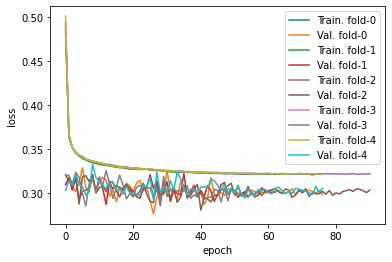

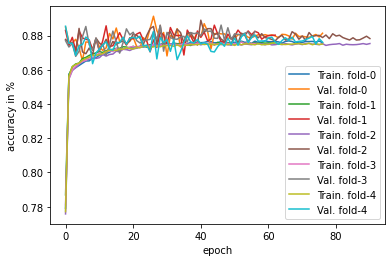

Best fold is fold number 0
Saving architecture to: /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/Model_13_04_2022/architecture.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/Model_13_04_2022/weights.h5


In [7]:
#Function for Kfold Crossvalidation Training, it returns a list of the history and a list of the the models
num_folds = 5
#history_list, model_list = Train_NN_Kfold(train, val, n_epochs, batch_size, num_folds)
Plot_Metrics(history_list, path_tosave)
best_fold = Find_Best_Fold(history_list)
Save_Model(model_list[best_fold], path_tosave)

from tensorflow.keras import layers as Kl
input_layer = Kl.Input(shape = input_shape )
x = Kl.Dense(64, activation='relu')(input_layer)
x = Kl.Dense(500, activation='relu') (x)
x = Kl.Dense(64, activation='relu') (x)
x = Kl.Dense(64, activation='relu') (x)
y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
model = Km.Model(inputs= input_layer, outputs=y_pred )
#model_optimizer = SGD(lr=0.00001)
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

input_shape = train[0].shape[1]
model = Create_Model_basic(input_shape)
fit_history = Train_NN(model, train, val, n_epochs, batch_size)
Plot_Metrics(fit_history, path_tosave)
Save_Model(model, path_tosave)

# Evaluation

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/Model_13_04_2022/architecture.json, /mnt/c/Users/aaron/Desktop/SSTT/CatNN/NN_for_sstt/Models/Model_13_04_2022/weights.h5)


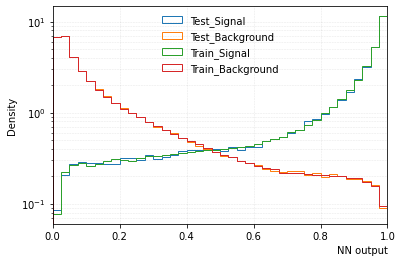

In [8]:
model=Load_Model(path_tosave)
Plot_NN_Output(model, train, test, path_tosave, True)

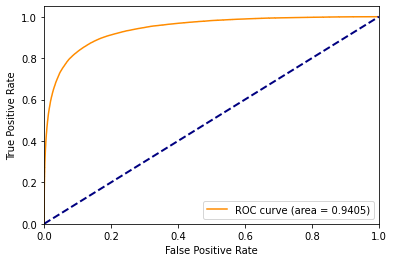

In [9]:
plot_roc_curve(model, test, path_tosave)

In [12]:
nn_scores_test = model.predict(test)
nn_scores = model.predict(train)

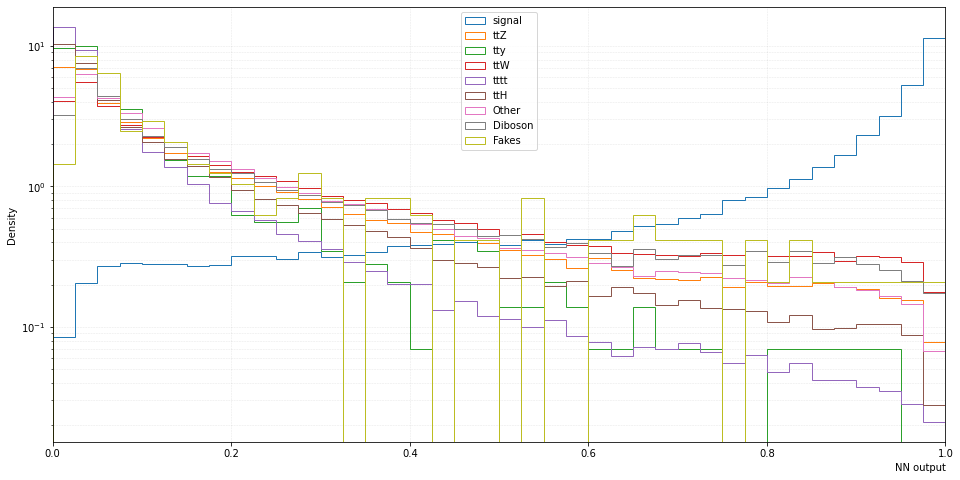

In [13]:
fig = plt.figure(figsize=(16,8))
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
for i in range(No_Classes):
    plt.hist(nn_scores_test[test[3]==i],label = class_names[i], **histargs)
plt.legend(loc='upper center')
    #plt.hist(nn_scores_test[test[1]==0][test[3]==i],label = "Test_Background", **histargs)
plt.savefig(path_tosave+"/NN_Output_Classes.png")

# Calc Signal cut for desired Singal Efficiency

In [14]:
Sig = nn_scores_test[test[1]==1]
Bkg = nn_scores_test[test[1]==0]
Sig_Eff, Bkg_Eff, Signal_Cut = Find_Eff_Cut(Sig=Sig, Bkg=Bkg, Signal_Eff=0.8)

Cut_Value: 0.613
Sig_Eff: 0.800
Bkg_Eff: 0.078
Bkg Rejection: 12.867


# Feature Importance

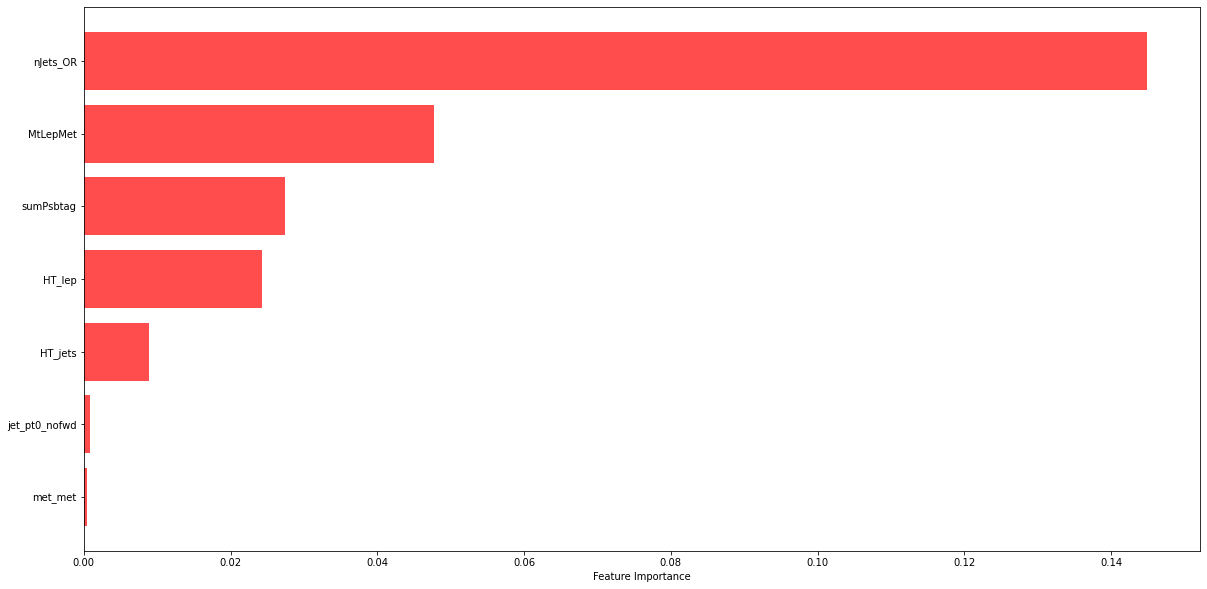

In [15]:
f = get_feature_importance(test, model, Signal_Cut, 10)
idx = np.argsort(f)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(range(test[0].shape[1]), np.sort(f), color="r", alpha=0.7)
ax.set_yticks(range(train[0].shape[1]), np.array(feature_names)[idx])
ax.set_xlabel('Feature Importance')
plt.savefig(path_tosave + "/Feature_Importance.png")

# Confusion Matrix

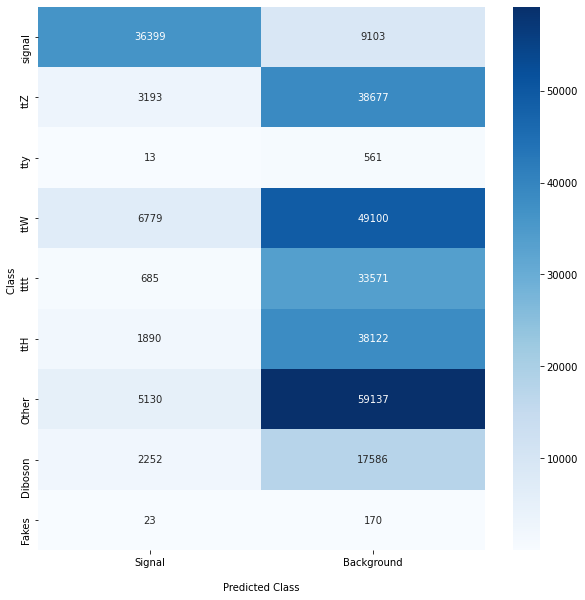

In [16]:
Make_Confusion_Matrix(test, nn_scores_test, Signal_Cut, class_names, path_tosave, False)

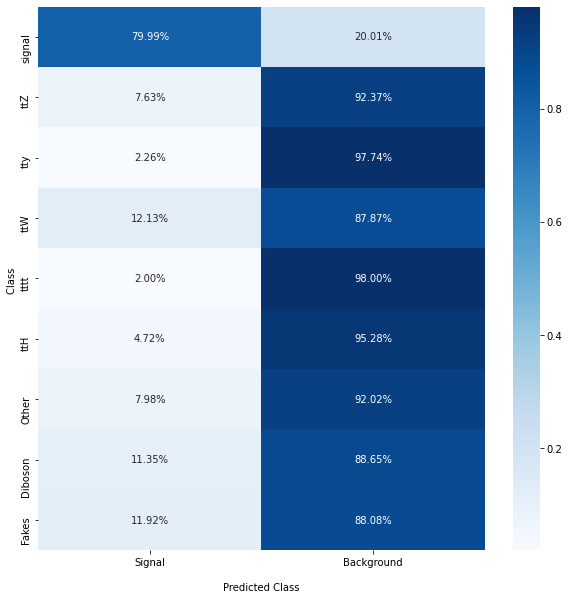

In [17]:
Make_Confusion_Matrix(test, nn_scores_test, Signal_Cut, class_names, path_tosave, True)